In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version = 1,as_frame=False)
mnist.keys()

X,y = mnist["data"], mnist["target"]
print(f"X: {X.shape} Y: {y.shape}")

#mnist784 is already in random order, so just take the final 10k out of 70 k as test set
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

X: (70000, 784) Y: (70000,)


In [2]:
#dimensionality reduction via PCA for speed - only train on training set
from sklearn.decomposition import PCA

pca_Xtrain_95 = PCA(n_components=0.95) #GMM is O(n^2 + n^3) so try to shrink
X_train_pca_95 = pca_Xtrain_95.fit_transform(X_train)

pca_Xtrain_95.n_components_



154

In [3]:
#dimensionality reduction via PCA for speed - only train on training set
from sklearn.decomposition import PCA

pca_Xtrain_99 = PCA(n_components=0.99) #GMM is O(n^2 + n^3) so try to shrink
X_train_pca_99 = pca_Xtrain_99.fit_transform(X_train)

pca_Xtrain_99.n_components_

331

In [4]:
def plot_reconstruction_error(pca, originals):
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt
    import numpy as np

    recon_error = []
    for original in originals:
        compressed = pca.transform(original.reshape(1, -1))
        reconstructed = pca.inverse_transform(compressed).reshape(original.shape)
        recon_error.append(mean_squared_error(original,reconstructed))

    worst_case = np.argmax(recon_error)
    print(f"Highest error for instance {worst_case} error = {recon_error[worst_case]}")
    plt.figure(figsize=(10,10))
    plt.title(f"Reconstruction error for PCA with {pca.n_components_} components from 784")
    plt.xlabel("Training instance")
    plt.ylabel("Reconstruction error")
    plt.scatter(range(len(X_train)),recon_error)
    plt.show()


Highest error for instance 2548 error = 637.7520192615202


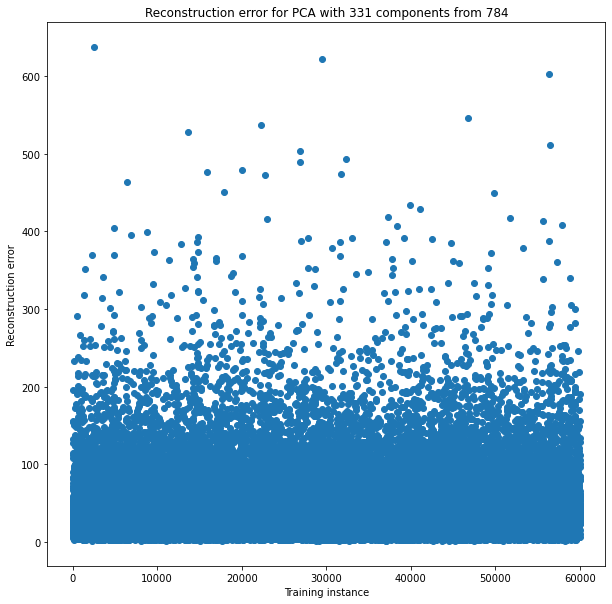

In [5]:
plot_reconstruction_error(pca_Xtrain_99,X_train)

Highest error for instance 13650 error = 1352.301952942335


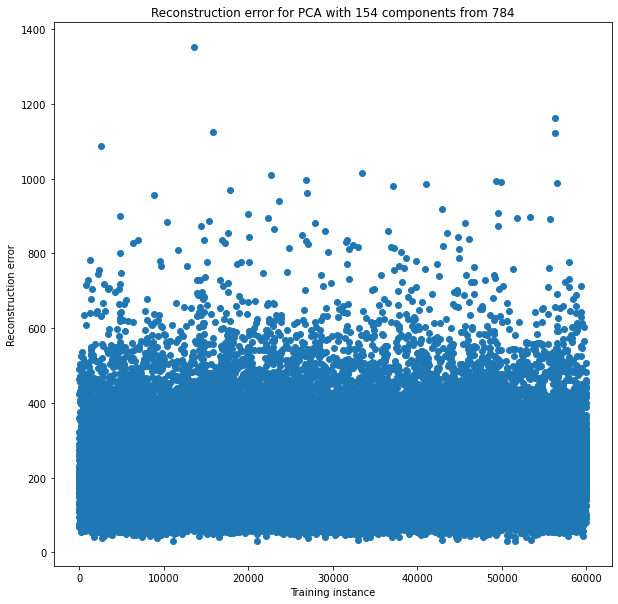

In [6]:
plot_reconstruction_error(pca_Xtrain_95,X_train)

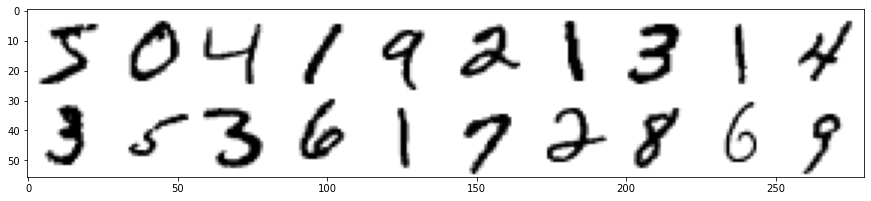

In [7]:

def show_images(instances, images_per_row=10):
    import numpy as np
    import matplotlib.pyplot as plt

    images_per_row = min(len(instances),images_per_row)
    nrows = (len(instances) -1)// images_per_row 
    nrows += 1
    row_images =[]
    pixels = int(np.sqrt(len(instances[0])))
    images = [instance.reshape((pixels,pixels)) for instance in instances]
    for row in range(nrows):
        row_image = images[row*images_per_row : (row+1)*images_per_row ]
        row_images.append(np.concatenate(row_image,axis=1))
    
    image = np.concatenate(row_images,axis=0)
    plt.figure(figsize=(15,15))
    plt.imshow(image, cmap="binary")
    plt.show()

show_images(X_train[:20])

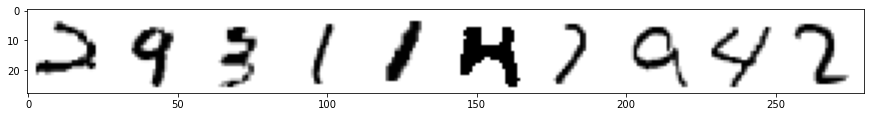

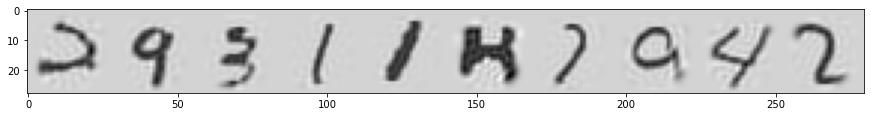

In [8]:
original_images = [X_train[_] for _ in range(13645,13655)]
recon_images = [pca_Xtrain_95.inverse_transform(X_train_pca_95[_].reshape(1,-1)).reshape(X_train[_].shape) for _ in range(13645,13655)]
show_images(original_images,10)
show_images(recon_images,10)

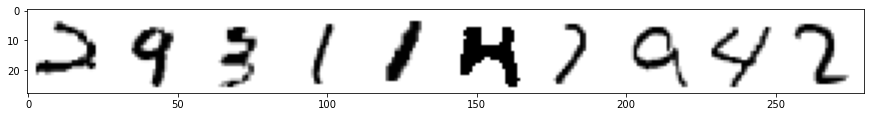

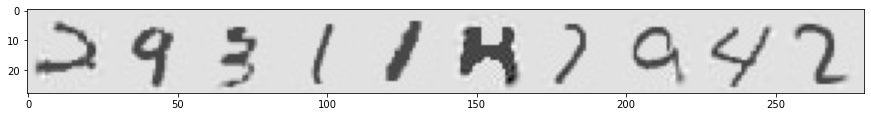

In [9]:
original_images = [X_train[_] for _ in range(13645,13655)]
recon_images = [pca_Xtrain_99.inverse_transform(X_train_pca_99[_].reshape(1,-1)).reshape(X_train[_].shape) for _ in range(13645,13655)]
show_images(original_images,10)
show_images(recon_images,10)

In [10]:
from sklearn.mixture import GaussianMixture

gmm_train = GaussianMixture(n_components=20,verbose=2).fit(X_train_pca_95)




Initialization 0
  Iteration 10	 time lapse 42.58837s	 ll change 0.78695
  Iteration 20	 time lapse 38.67811s	 ll change 0.15395
  Iteration 30	 time lapse 38.33478s	 ll change 0.05443
  Iteration 40	 time lapse 38.04114s	 ll change 0.01997
  Iteration 50	 time lapse 37.96475s	 ll change 0.01098
  Iteration 60	 time lapse 37.67402s	 ll change 0.04166
  Iteration 70	 time lapse 37.43375s	 ll change 0.00717
  Iteration 80	 time lapse 37.58883s	 ll change 0.00176
Initialization converged: True	 time lapse 334.41358s	 ll -764.39489


### Since the GMM didn't converge set warm_start and continue:

In [11]:
#trying with warm_start
gmm_train.warm_start = True
gmm_train.fit(X_train_pca_95)

Initialization 0
Initialization converged: True	 time lapse 3.99641s	 ll -764.39441


GaussianMixture(n_components=20, verbose=2, warm_start=True)

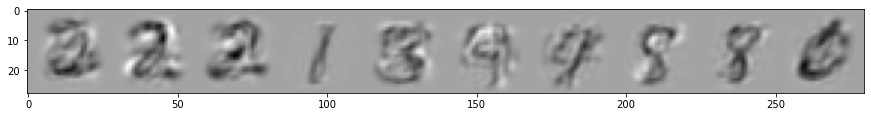

In [13]:
#Sample from the 0.95 PCA
import numpy as np
new_digits = []
new_sample = gmm_train.sample(10)
for _ in new_sample[0]:
    new_digits.append(pca_Xtrain_95.inverse_transform(_))
show_images(np.array(new_digits),10)

In [21]:
print(gmm_train.converged_)
print(np.unique(gmm_train.predict(X_train_pca_95)))

True
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [24]:
# So uses all 20 - try using BGM to find optimal number
from sklearn.mixture import BayesianGaussianMixture

bgm_95 = BayesianGaussianMixture(max_iter = 100, verbose = 2, n_components=100).fit(X_train_pca_95)

Initialization 0
  Iteration 10	 time lapse 299.05747s	 ll change 9651.38503
  Iteration 20	 time lapse 273.15658s	 ll change 3816.11222
  Iteration 30	 time lapse 268.89475s	 ll change 596.87980
  Iteration 40	 time lapse 257.97688s	 ll change 724.34513
  Iteration 50	 time lapse 258.91546s	 ll change 1085.86475
  Iteration 60	 time lapse 258.41711s	 ll change 83.92630
  Iteration 70	 time lapse 259.72866s	 ll change 46.87219
  Iteration 80	 time lapse 261.61811s	 ll change 62.81557
  Iteration 90	 time lapse 258.48748s	 ll change 18.95185
  Iteration 100	 time lapse 262.18671s	 ll change 0.01006
Initialization converged: False	 time lapse 2658.43920s	 ll -49042730.32994


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


In [25]:
bgm_95.warm_start=True
bgm_95.fit(X_train_pca_95)


Initialization 0
  Iteration 10	 time lapse 264.98901s	 ll change 0.31100
  Iteration 20	 time lapse 267.32132s	 ll change 1.96199
  Iteration 30	 time lapse 264.37109s	 ll change 0.01362
Initialization converged: True	 time lapse 981.53093s	 ll -49042375.36398


BayesianGaussianMixture(n_components=100, verbose=2, warm_start=True)

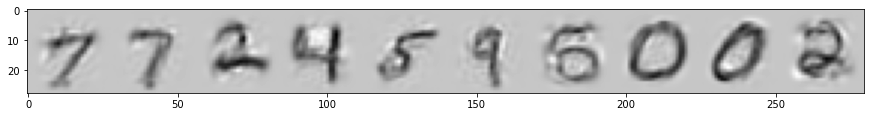

In [26]:
import numpy as np
new_digits_bgm95 = []
new_sample = bgm_95.sample(10)
for _ in new_sample[0]:
    new_digits_bgm95.append(pca_Xtrain_95.inverse_transform(_))
show_images(np.array(new_digits_bgm95),10)

In [28]:
print(f"no of components out of 100 used: {len(np.unique(bgm_95.predict(X_train_pca_95)))}")

no of components out of 100 used: 100


In [29]:
import joblib
joblib.dump(bgm_95,"bgm_95_100.pkl")


['bgm_95_100.pkl']

In [32]:
iter = 1
bgm_95_500 = BayesianGaussianMixture(n_components=500,verbose=2,max_iter=1, warm_start=True)
bgm_95_500.fit(X_train_pca_95)


Initialization 0
Initialization converged: False	 time lapse 209.88220s	 ll -85201272.86850


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


BayesianGaussianMixture(max_iter=1, n_components=500, verbose=2,
                        warm_start=True)

In [33]:
#This will take 15+ hours so do save in 20 minute sections
bgm_95_500.warm_start=True
bgm_95_500.max_iter=5
while (bgm_95_500.converged_ == False) and (iter < 200):
    bgm_95_500.fit(X_train_pca_95)
    iter+=5
    joblib.dump(bgm_95_500,f"bgm_95_500_{iter}.pkl")

print(f"complete! converged = {bgm_95_500.converged_}")

Initialization 0
Initialization converged: False	 time lapse 600.95018s	 ll -85160788.08218


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 590.35632s	 ll -85066394.48346


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 614.47109s	 ll -84986992.61264


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 638.54072s	 ll -84941911.74271


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 580.14400s	 ll -84936780.10283


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 576.98102s	 ll -84934399.88124


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 551.16655s	 ll -84933549.58875


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 556.97873s	 ll -84933492.89488


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 553.47232s	 ll -84933492.82988


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 545.57844s	 ll -84933492.24349


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 518.68354s	 ll -84933491.57303


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 523.50350s	 ll -84933490.67562


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 526.65699s	 ll -84933485.41587


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 531.86014s	 ll -84933474.05108


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 536.01833s	 ll -84933432.01184


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 530.92307s	 ll -84933416.80500


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 526.23918s	 ll -84933415.17060


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 536.85232s	 ll -84933415.15596


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 561.36508s	 ll -84933415.14542


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: False	 time lapse 556.14318s	 ll -84933415.12081


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0


KeyboardInterrupt: 

In [11]:
import joblib
#sklearn.PCA *may* have used random. If this is the case then the newly generated PCA will be different from the one that is traioned on - look for LL measure!!!
bgm_95_500 = joblib.load("bgm_95_500_101.pkl")
iter = 101
while (bgm_95_500.converged_ == False) and (iter < 200):
    bgm_95_500.fit(X_train_pca_95)
    iter+=5
    joblib.dump(bgm_95_500,f"bgm_95_500_{iter}.pkl")

print(f"complete! converged = {bgm_95_500.converged_}")

Initialization 0
Initialization converged: False	 time lapse 552.40555s	 ll -84933415.08986


c:\Users\micha\anaconda3\envs\PandasNumpyMathplotlib\lib\site-packages\sklearn\mixture\_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '


Initialization 0
Initialization converged: True	 time lapse 222.41418s	 ll -84933415.08701
complete! converged = True


In [12]:
joblib.dump(bgm_95_500,"bgm_500_112_final.pkl")

['bgm_500_112_final.pkl']

In [15]:
import numpy as np
print(f"no of Gaussians out of 500 used by BGM: {len(np.unique(bgm_95_500.predict(X_train_pca_95)))}")

no of Gaussians out of 500 used by BGM: 500


Comparing Sampled images from the 0.95 compressed MNIST784 to original and reconstructed images:

Original Images


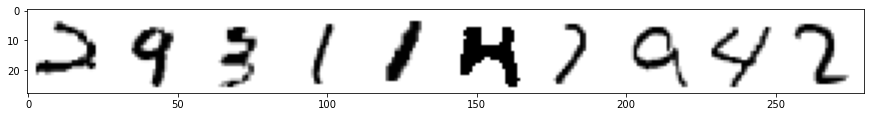

images after compression and reconstruction


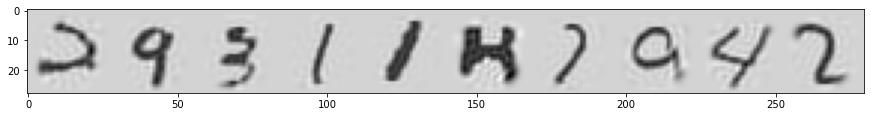

In [22]:
original_images = [X_train[_] for _ in range(13645,13655)]
recon_images = [pca_Xtrain_95.inverse_transform(X_train_pca_95[_].reshape(1,-1)).reshape(X_train[_].shape) for _ in range(13645,13655)]
print("Original Images")
show_images(original_images,10)
print("images after compression and reconstruction")
show_images(recon_images,10)

new digits created by sampling from BGM with up to 500 components of 0.95 PCA compressed Mnist 784


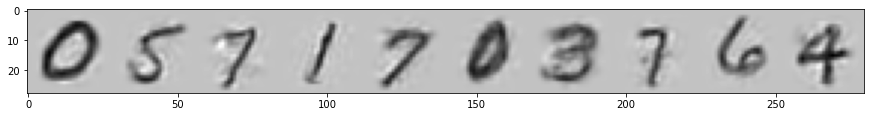

In [24]:
import numpy as np
new_digits_bgm95_500 = []
new_sample = bgm_95_500.sample(10)
for _ in new_sample[0]:
    new_digits_bgm95_500.append(pca_Xtrain_95.inverse_transform(_))
print("new digits created by sampling from BGM with up to 500 components of 0.95 PCA compressed Mnist 784")
show_images(np.array(new_digits_bgm95_500),10)